# full_cyto_to_shapely

Convert a cytoscape graph to a series of polygons and lines in shapely

Returns dictionary of shapes and dictionary of lines
shapes = {
    suid: shape
}
lines = {
    suid: {
        line: line,
        source: source suid,
        target: target suid
    }
}

%run cyto_to_shapely_node.ipynb
%run cyto_to_shapely_edge.ipynb

In [1]:
from py2cytoscape import cyrest
import requests

def full_cyto_to_shapely(network_suid, view_suid):
    cy = cyrest.cyclient()
    nodes_info = _get_node_info(network_suid, view_suid, cy)
    edges_info = _get_edge_info(network_suid, view_suid, cy)
    shapes = _make_shapes(nodes_info)
    lines, neighbors = _make_lines(nodes_info, edges_info, shapes)
    for shape_suid in shapes.keys():
        shapes[shape_suid]['neighbors'] = neighbors[shape_suid]
    return shapes, lines

def _make_shapes(nodes_info):
    shapes = {}
    for node_suid, node_info in nodes_info.items():
        shapes[node_suid] = {
            'shape': cyto_to_shapely_node(
                         node_info['shape'], 
                         node_info['height'],
                         node_info['width'],
                         node_info['x'],
                         node_info['y'],
                         0
                     ),
            'x': node_info['x'],
            'y': node_info['y'],
            'height': node_info['height'],
            'neighbors': []
        }
        
    return shapes

def _make_lines(nodes_info, edges_info, shapes):
    initial_lines = {}
    for edge_suid, edge_info in edges_info.items():   
        source_x = nodes_info[str(edge_info['source'])]['x']
        source_y = nodes_info[str(edge_info['source'])]['y']
        target_x = nodes_info[str(edge_info['target'])]['x']
        target_y = nodes_info[str(edge_info['target'])]['y']
        
        initial_lines[edge_suid] = {
            'line': cyto_to_shapely_edge(
                source_x,
                source_y,
                target_x,
                target_y
            ),
            'source': str(edge_info['source']),
            'target': str(edge_info['target'])
        }
        
    #Clip lines before they enter their source and target nodes
    refined_lines = {}
    neighbors = {}
    for line_suid, line_info in initial_lines.items():
        source_suid = line_info['source']
        target_suid = line_info['target']
        line = line_info['line']
        source = shapes[source_suid]['shape'].boundary
        target = shapes[target_suid]['shape'].boundary
        
        if line.intersects(source):
            source_coord = line.intersection(source)
            source_x = source_coord.x
            source_y = source_coord.y
        if line.intersects(target):
            target_coord = line.intersection(target)
            target_x = target_coord.x
            target_y = target_coord.y
                
        refined_lines[line_suid] = {
            'line': cyto_to_shapely_edge(
                source_x,
                source_y,
                target_x,
                target_y
            ),
            'source': source_suid,
            'target': target_suid
        }
        
        if source_suid in neighbors:
            neighbors[source_suid].append(target_suid)
        else:
            neighbors[source_suid] = [target_suid]
        if target_suid in neighbors:
            neighbors[target_suid].append(source_suid)
        else:
            neighbors[target_suid] = [source_suid]
        
    return refined_lines, neighbors

def _get_node_info(network_suid, view_suid, cy):
    response = cy.node.get_attribute(columnList='SUID', nodeList='all', network='SUID:' + str(network_suid))
    node_suids = [str(item['SUID']) for item in response]

    nodes_info = {}
    base_url = 'http://localhost:1234/v1/networks/' + str(network_suid) + '/views/' + str(view_suid) + '/nodes/'
    for suid in node_suids:
        url = base_url + suid
        response_1 = requests.get(url).json()
        info_1 = {
            'height': [prop['value'] for prop in response_1 if prop['visualProperty'] == 'NODE_HEIGHT'][0],
            'width': [prop['value'] for prop in response_1 if prop['visualProperty'] == 'NODE_WIDTH'][0],
            'shape': [prop['value'] for prop in response_1 if prop['visualProperty'] == 'NODE_SHAPE'][0],
            'x': [prop['value'] for prop in response_1 if prop['visualProperty'] == 'NODE_X_LOCATION'][0],
            'y': [prop['value'] for prop in response_1 if prop['visualProperty'] == 'NODE_Y_LOCATION'][0]
        }

        response_2 = requests.get(url).json()
        info_2 = {
            'height': [prop['value'] for prop in response_2 if prop['visualProperty'] == 'NODE_HEIGHT'][0],
            'width': [prop['value'] for prop in response_2 if prop['visualProperty'] == 'NODE_WIDTH'][0],
            'shape': [prop['value'] for prop in response_2 if prop['visualProperty'] == 'NODE_SHAPE'][0],
            'x': [prop['value'] for prop in response_2 if prop['visualProperty'] == 'NODE_X_LOCATION'][0],
            'y': [prop['value'] for prop in response_2 if prop['visualProperty'] == 'NODE_Y_LOCATION'][0]
        }

        if info_1 != info_2:
            responses = [info_1, info_2]
            no_match = True
            while no_match:
                response_new = requests.get(url).json()
                info_new = {
                    'height': [prop['value'] for prop in response_new if prop['visualProperty'] == 'NODE_HEIGHT'][0],
                    'width': [prop['value'] for prop in response_new if prop['visualProperty'] == 'NODE_WIDTH'][0],
                    'shape': [prop['value'] for prop in response_new if prop['visualProperty'] == 'NODE_SHAPE'][0],
                    'x': [prop['value'] for prop in response_new if prop['visualProperty'] == 'NODE_X_LOCATION'][0],
                    'y': [prop['value'] for prop in response_new if prop['visualProperty'] == 'NODE_Y_LOCATION'][0]
                }
                for i in range(len(responses)):
                    if info_new == responses[i]:
                        nodes_info[suid] = info_new
                        no_match = False
                        break
                    else:
                        responses.append(info_new)

        else:
            nodes_info[suid] = info_1

    return nodes_info

def _get_edge_info(network_suid, view_suid, cy):
    response = cy.edge.get_attribute(columnList='SUID', edgeList='all', network='SUID:' + str(network_suid))
    edge_suids = [str(item['SUID']) for item in response]
    
    edges_info = {}
    
    base_url = 'http://localhost:1234/v1/networks/' + str(network_suid) + '/edges/'
    for suid in edge_suids:
        url = base_url + suid
        response = requests.get(url).json()
        edges_info[suid] = {
            'source': response['data']['source'],
            'target': response['data']['target']
        }
    return edges_info

(324.3836076962743, -230.0163923037257)

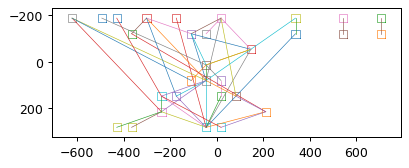